# Dogs vs Cats

구글 드라이브 문서에 있는 dogs-vs-cats.zip을 다운받으셔서 압축을 풀고 진행하시면 됩니다.  
숙제는 목차의 `3. Modeling`부분을 수정해서 현 문서에 있는 Acc보다 더 나은 점수를 내시면 됩니다.  
당연히 전체적으로 문서를 뒤엎어 고쳐도 상관없습니다. 모델을 더 깊게 쌓아보거나, 얇게 해볼수도 있고, 하이퍼파라미터를 수정할 수도 있고, 데이터 자체에 대한 정규화를 해서 적용시킬수도 있고, lr_sche를 추가해볼수도 있고, data_augmentation을 추가할수도 있고, 비용함수나 최적화기법을 바꿀수도, dropout, batch_norm, initialization 기법 등 전에 배웠거나 안배웠던 것들도 모두 사용하시면 됩니다.     


해당 데이터는 케글에서 가져온 것으로 검색해보면 많은 모델링을 찾아보실 수 있습니다.  
전이학습은 안됩니다. 월등한 점수를 내기보다 연습한다는 생각으로 모델 아키텍을 해보시길 바랍니다.  

   **< 목차 >**
1. Setting
 - 1) Import libraries
 - 2) Hyperparameters
2. Data
 - 1) Get Images
 - 2) Use DataLoader
 - 3) Check Images
3. Modeling
4. Loss Function & Optimizer
5. Train
 - 1) Train
 - 2) Test

## 1. Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1) Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


#### 2) Hyperparamters

In [ ]:
batch_size = 32
learning_rate = 0.003
epochs = 15
image_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
])


## 2. Data

#### 1) Get Images

In [ ]:

train_dir = './train2/train'
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)

valid_dir = './train2/valid'
valid_data = datasets.ImageFolder(root=valid_dir, transform=test_transforms)

test_dir = './train2/test'
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/train2/train'
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)

valid_dir = '/content/drive/MyDrive/Colab Notebooks/train2/valid'
valid_data = datasets.ImageFolder(root=valid_dir, transform=test_transforms)

test_dir = '/content/drive/MyDrive/Colab Notebooks/train2/test'
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

#### 2) Use DataLoader

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)
    # batch_size에 맞춰서 drop_last 처리로 해줘야 하는 이유: 마지막에 몇개 남을시 forward에서 view이후 size_mismatch오류가 일어남
print(f'train images: {len(train_loader.dataset)}')
print(f'valid images: {len(valid_loader.dataset)}')
print(f'test images: {len(test_loader.dataset)}')

train images: 20000
valid images: 2500
test images: 2500


#### 3) Check Images

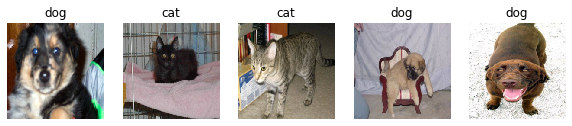

In [ ]:
np.random.seed(42)
random_nums = [np.random.randint(1, 20001) for i in range(5)]

plt.figure(figsize=(10, 2))
for i in range(len(random_nums)):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(train_loader.dataset[random_nums[i]][0], (1,2,0)))
    plt.title(f'{"cat" if train_loader.dataset[random_nums[i]][1] == 0 else "dog"}')
    plt.axis('off')

In [ ]:
batch_image, batch_label = next(iter(train_loader))
print(batch_image.shape)
print(batch_label.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


## 3. Modeling

In [ ]:
# Acc 0.87의 모델
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), # 224 -> 224
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2) # 224 -> 112
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), # 112 -> 56
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2) # 56 -> 28
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 28 -> 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2) # 28 -> 14
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 14 -> 7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7 -> 3
        )        
        self.layer_5 = nn.Sequential(
            nn.Linear(64 * 3 * 3, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 2),           
        )

        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)

        
    def forward(self, x):
        out = self.layer_1(x) 
        out = self.layer_2(out) 
        out = self.layer_3(out) 
        out = self.layer_4(out)
        out = out.view(batch_size, -1)
                                       
        out = self.layer_5(out)
        return out

홍록님 모델링 + 지평님 Mish

In [ ]:
# Mish activation function
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [ ]:
# make conv_block
def conv_block(shape, in_, out_, kernel_size, stride=1, padding=0):
    block = torch.nn.Sequential(
      nn.Conv2d(in_, out_, kernel_size, stride=stride, padding=padding, bias=False), # bias는 batchNorm에서 베타값이 대체함
      nn.BatchNorm2d(out_),
      Mish(),
    )
    shape = int(np.floor((shape - kernel_size + 2 * padding) / stride) + 1)
    return block, shape

def fc_block(in_, out_):
    block = torch.nn.Sequential(
      torch.nn.Linear(in_, out_, bias=False),
      torch.nn.BatchNorm1d(out_),
      Mish()
    )
    return block

In [ ]:
# Acc 0.92의 모델
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1, self.shape = conv_block(224, 3, 8, 3, padding=1)
        self.conv_block2, self.shape = conv_block(self.shape, 8, 16, 3, stride=2)
        self.conv_block3, self.shape = conv_block(self.shape, 16, 16, 3, padding=1)
        self.conv_block4, self.shape = conv_block(self.shape, 16, 32, 3, stride=2)
        self.conv_block5, self.shape = conv_block(self.shape, 32, 32, 3, padding=1)
        self.conv_block6, self.shape = conv_block(self.shape, 32, 64, 3, stride=2)
        self.conv_block7, self.shape = conv_block(self.shape, 64, 64, 3, padding=1)
        self.conv_block8, self.shape = conv_block(self.shape, 64, 128, 3, stride=2)

        self.fc_block1 = fc_block(128 * self.shape * self.shape, 256)
        self.fc_block2 = fc_block(256, 64)
        self.fc_last = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = self.conv_block7(x)
        x = self.conv_block8(x)
        x = x.view(batch_size, -1)
        x = self.fc_block1(x)
        x = self.fc_block2(x)
        x = self.fc_last(x)
        return x

In [ ]:
model = CNN()
temp_prediction = model(batch_image)
print(temp_prediction.shape)

torch.Size([32, 10])


## 4. Loss_funtion & Optimizer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

cuda
CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (conv_block3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (conv_block4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (conv_block5): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): B

## 5. Train

#### **1) Train**

In [ ]:
train_loss_arr = []
valid_loss_arr = []

for epoch in range(epochs):
    start = time.time()
    train_avg_loss = 0
    train_acc = 0
    model.train()
    for image, label in train_loader:
        # ------- assign train data
        image = image.to(device)
        label = label.to(device)
        # ------- forward prop
        optimizer.zero_grad()
        output = model(image)
        # ------- backward prop
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()
        # ------- get train performance
        batch_acc = ((output.argmax(dim=1) == label).float().mean())
        train_acc += batch_acc / len(train_loader)
        train_avg_loss += loss / len(train_loader)
    train_loss_arr.append(train_avg_loss)
    print(f'Epoch : {epoch+1}/{epochs}, train_acc : {train_acc:.4f}, train_loss : {train_avg_loss:.4f}', end=' / ')
     
    model.eval()
    with torch.no_grad():
        valid_acc=0
        valid_avg_loss =0
        for image, label in valid_loader:
            # ------- assign valid data
            image = image.to(device)
            label = label.to(device)
            # ------- forward prop
            val_output = model(image)
            val_loss = loss_func(val_output,label)
            # ------- get valid performance
            val_batch_acc = ((val_output.argmax(dim=1) == label).float().mean()) # acc = 맞춘 개수 / 배치사이즈
            valid_acc += val_batch_acc / len(valid_loader) # acc / total_Iteration 
            valid_avg_loss += val_loss / len(valid_loader) # val_loss / total_Iteration
        valid_loss_arr.append(valid_avg_loss) 
        print(f'valid_acc : {valid_acc:.4f}, val_loss : {valid_avg_loss:.4f}, takes {time.time() - start}secs')

C:\Users\82105\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  # Remove the CWD from sys.path while we load stuff.


Epoch : 1/15, train_acc : 0.6660, train_loss : 0.6547 / valid_acc : 0.6054, val_loss : 0.8664, takes 220.83394384384155secs
Epoch : 2/15, train_acc : 0.7496, train_loss : 0.5103 / valid_acc : 0.7500, val_loss : 0.4984, takes 199.5979392528534secs
Epoch : 3/15, train_acc : 0.8005, train_loss : 0.4362 / valid_acc : 0.8249, val_loss : 0.3970, takes 210.30927896499634secs
Epoch : 4/15, train_acc : 0.8336, train_loss : 0.3812 / valid_acc : 0.8522, val_loss : 0.3436, takes 227.38459062576294secs
Epoch : 5/15, train_acc : 0.8530, train_loss : 0.3385 / valid_acc : 0.8538, val_loss : 0.3360, takes 226.9936397075653secs
Epoch : 6/15, train_acc : 0.8754, train_loss : 0.2967 / valid_acc : 0.8658, val_loss : 0.3230, takes 229.45704436302185secs
Epoch : 7/15, train_acc : 0.8930, train_loss : 0.2598 / valid_acc : 0.8870, val_loss : 0.2773, takes 229.7801811695099secs
Epoch : 8/15, train_acc : 0.9071, train_loss : 0.2265 / valid_acc : 0.9050, val_loss : 0.2399, takes 232.47497010231018secs
Epoch : 9/1

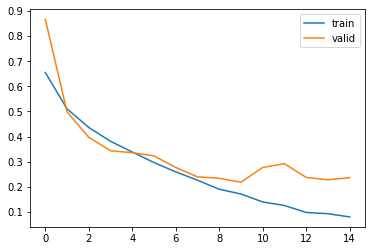

In [ ]:
plt.plot(train_loss_arr, label='train')
plt.plot(valid_loss_arr, label='valid')
plt.legend()
plt.show()

#### **2) Test**

In [ ]:
with torch.no_grad():
    start = time.time()
    test_acc=0
    for image, label in test_loader:
        # ------- assign valid data
        image = image.to(device)
        label = label.to(device)
        # ------- forward prop
        test_output = model(image)
        # ------- get valid performance
        test_batch_acc = ((test_output.argmax(dim=1) == label).float().mean()) # acc = 맞춘 개수 / 배치사이즈
        test_acc += test_batch_acc / len(test_loader) # acc / total_Iteration 
    print(f'test_acc : {test_acc:.4f}, takes {time.time() - start}secs')

test_acc : 0.9239, takes 29.651660919189453secs


**Fin** ────────────────────────────────────────────────────────────────────────────────────────────────